### Import necessary libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


### Import dataset

In [7]:
df = pd.read_csv('Meteorite_Landings.csv')
df.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation,Unnamed: 10
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)",NaN
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)",NaN
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)",NaN
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)",NaN
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)",NaN


### Details about the data

In [9]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass (g)     45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
 10  Unnamed: 10  0 non-null      float64
dtypes: float64(5), int64(1), object(5)
memory usage: 3.8+ MB


,id,mass (g),year,reclat,reclong,Unnamed: 10
count,45716.000000,4.558500e+04,45425.000000,38401.000000,38401.000000,0.0
mean,26889.735104,1.327808e+04,1991.828817,-39.122580,61.074319,NaN
std,16860.683030,5.749889e+05,25.052766,46.378511,80.647298,NaN
min,1.000000,0.000000e+00,860.000000,-87.366670,-165.433330,NaN
25%,12688.750000,7.200000e+00,1987.000000,-76.714240,0.000000,NaN
50%,24261.500000,3.260000e+01,1998.000000,-71.500000,35.666670,NaN
75%,40656.750000,2.026000e+02,2003.000000,0.000000,157.166670,NaN
max,57458.000000,6.000000e+07,2101.000000,81.166670,354.473330,NaN


In [10]:
print("Column Names:", df.columns.tolist())
rows, cols = df.shape

#Before Cleaning
print(f"The DataFrame has {rows} rows and {cols} columns.")

Column Names: ['name', 'id', 'nametype', 'recclass', 'mass (g)', 'fall', 'year', 'reclat', 'reclong', 'GeoLocation', 'Unnamed: 10']
The DataFrame has 45716 rows and 11 columns.


In [11]:
from plotly import io

io.renderers.default = 'iframe'
px.bar(data_frame=df['recclass'].value_counts().to_frame().reset_index().head(n=40), x='recclass', y='count')

## Data Cleaning and Preprocessing

In [13]:
# Check for missing values
df.isnull().sum()

name               0
id                 0
nametype           0
recclass           0
mass (g)         131
fall               0
year             291
reclat          7315
reclong         7315
GeoLocation     7315
Unnamed: 10    45716
dtype: int64

In [14]:
# Drop the 'Unnamed: 10' column, seems all the row's are missing values
df.drop(columns=['Unnamed: 10'], inplace=True)

# Handling missing values
df = df.dropna(subset=['mass (g)', 'year', 'reclat', 'reclong'])

df

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"
...,...,...,...,...,...,...,...,...,...,...
45711,Zillah 002,31356,Valid,Eucrite,172.0,Found,1990.0,29.03700,17.01850,"(29.037, 17.0185)"
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,Found,1999.0,13.78333,8.96667,"(13.78333, 8.96667)"
45713,Zlin,30410,Valid,H4,3.3,Found,1939.0,49.25000,17.66667,"(49.25, 17.66667)"
45714,Zubkovsky,31357,Valid,L6,2167.0,Found,2003.0,49.78917,41.50460,"(49.78917, 41.5046)"


## Code Segment for outlier manipulation

In [16]:
# q1 = df['mass (g)'].quantile(0.25)
# q3 = df['mass (g)'].quantile(0.75)
# iqr = q3 - q1

# required_k = (6000 - q3) / iqr
# print(f"Required IQR multiplier: {required_k:.2f}")


In [17]:
# #filter the outliers using IQR
# def filter_by_iqr(df):
#     numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
#     for col in numeric_cols:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower = Q1 - 33 * IQR
#         upper = Q3 + 33 * IQR
#         df = df[(df[col] >= lower) & (df[col] <= upper)]
#     return df

# df = filter_by_iqr(df)



In [18]:
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38115 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         38115 non-null  object 
 1   id           38115 non-null  int64  
 2   nametype     38115 non-null  object 
 3   recclass     38115 non-null  object 
 4   mass (g)     38115 non-null  float64
 5   fall         38115 non-null  object 
 6   year         38115 non-null  float64
 7   reclat       38115 non-null  float64
 8   reclong      38115 non-null  float64
 9   GeoLocation  38115 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.2+ MB


In [19]:
# After cleaning
af_rows, af_cols = df.shape

# DataFrame shape before and after cleaning
print("DataFrame Shape Summary")
print("-" * 30)
print(f"Before Cleaning : {rows:,} rows × {cols:,} columns")
print(f"After Cleaning  : {af_rows:,} rows × {af_cols:,} columns")


DataFrame Shape Summary
------------------------------
Before Cleaning : 45,716 rows × 11 columns
After Cleaning  : 38,115 rows × 10 columns


### Convert 'year' to datetime

In [21]:
# Convert 'year' to datetime
print(f"Before Conversion: {df['year'].dtype}")

# Convert 'year' to datetime
df['year'] = pd.to_datetime(df['year'], format='%Y', errors='coerce')
print(f"After Conversion : {df['year'].dtype}")

Before Conversion: float64
After Conversion : datetime64[ns]


### Convert 'fall' column to binary encoding

In [23]:
df['fall'] = df['fall'].str.strip().str.capitalize()
print(df['fall'].unique())

df['fall'] = df['fall'].map({'Fell': 1, 'Found': 0})
#checking values correctness after conversion
print(df['fall'])
print(f"After Conversion : {df['fall'].isnull().sum()}")

['Fell' 'Found']
0        1
1        1
2        1
3        1
4        1
        ..
45711    0
45712    0
45713    0
45714    0
45715    0
Name: fall, Length: 38115, dtype: int64
After Conversion : 0


In [24]:
# Display the cleaned data
df

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,1,1880-01-01,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,1,1951-01-01,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,1,1952-01-01,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,1,1976-01-01,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,1,1902-01-01,-33.16667,-64.95000,"(-33.16667, -64.95)"
...,...,...,...,...,...,...,...,...,...,...
45711,Zillah 002,31356,Valid,Eucrite,172.0,0,1990-01-01,29.03700,17.01850,"(29.037, 17.0185)"
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,0,1999-01-01,13.78333,8.96667,"(13.78333, 8.96667)"
45713,Zlin,30410,Valid,H4,3.3,0,1939-01-01,49.25000,17.66667,"(49.25, 17.66667)"
45714,Zubkovsky,31357,Valid,L6,2167.0,0,2003-01-01,49.78917,41.50460,"(49.78917, 41.5046)"


## Exploratory Data Analysis (EDA)

In [26]:
print(df['nametype'].value_counts())
print("-" * 30)
print(df['fall'].value_counts())  # 'Fell' vs 'Found'


nametype
Valid     38094
Relict       21
Name: count, dtype: int64
------------------------------
fall
0    37050
1     1065
Name: count, dtype: int64


### Univariate Analysis

#### Fell vs Found Comparison

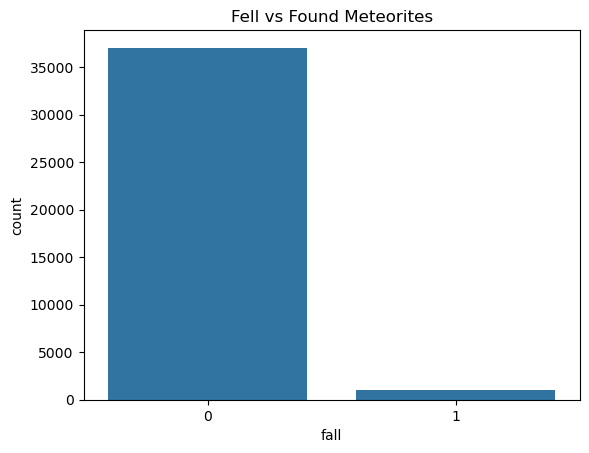

In [29]:
# Count plot for fall status
sns.countplot(x='fall', data=df)
plt.title("Fell vs Found Meteorites")
plt.show()

#### Histogram for mass (g)

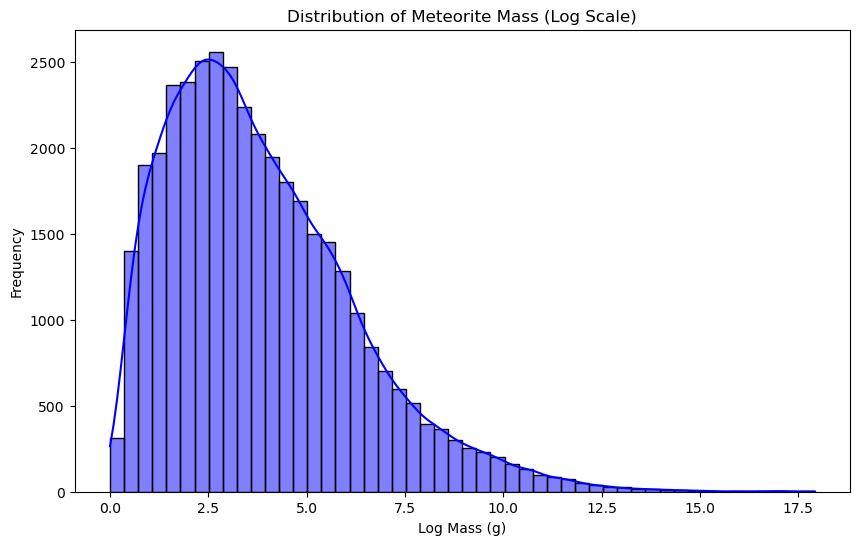

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['mass (g)']), bins=50, kde=True, color='blue')
plt.xlabel('Log Mass (g)')
plt.ylabel('Frequency')
plt.title('Distribution of Meteorite Mass (Log Scale)')
plt.show()

In [32]:
# Create an interactive map
fig = px.scatter_geo(df,
                     lon='reclong',
                     lat='reclat',
                     color='fall',
                     hover_name='name',
                     hover_data=['mass (g)', 'recclass'],
                     projection='natural earth',
                     title='Meteorite Falls vs Found Map')

# Update layout
fig.update_geos(showcountries=True, showland=True, landcolor="lightgray", showocean=True, oceancolor="lightblue")
fig.update_layout(height=600, margin={"r": 0, "t": 30, "l": 0, "b": 0})

# Show the map
fig.show()

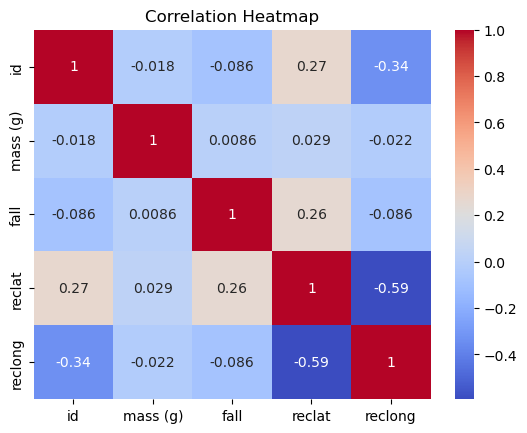

                id  mass (g)      fall    reclat   reclong
id        1.000000 -0.017916 -0.086009  0.267175 -0.335238
mass (g) -0.017916  1.000000  0.008604  0.029235 -0.021854
fall     -0.086009  0.008604  1.000000  0.255963 -0.086060
reclat    0.267175  0.029235  0.255963  1.000000 -0.593234
reclong  -0.335238 -0.021854 -0.086060 -0.593234  1.000000


In [33]:
# Visualize the correlation between numeric features
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
print(correlation_matrix)

In [34]:
# Convert 'year' to datetime and extract year as integer
df['year'] = pd.to_datetime(df['year'], errors='coerce')
df['year_int'] = df['year'].dt.year

# Filter using the integer year
df_recent = df[(df['year_int'] > 1970) & (df['year_int'] < 2025)]

# Now plot with Plotly
import plotly.express as px

fig = px.scatter_mapbox(
    data_frame=df_recent,
    lat='reclat',
    lon='reclong',
    color='year_int',              # or use 'year' if you prefer a datetime color scale
    size='mass (g)',
    size_max=15,
    hover_name='name',
    hover_data={
        'recclass': True,
        'mass (g)': True,
        'year_int': True
    },
    mapbox_style='carto-darkmatter',
    zoom=1,
    center={'lat': 0, 'lon': 0},
    title="Meteorite Falls (1970 - 2024) Visualized on Map",
    height=800,
    color_continuous_scale='Viridis'
)

fig.show()

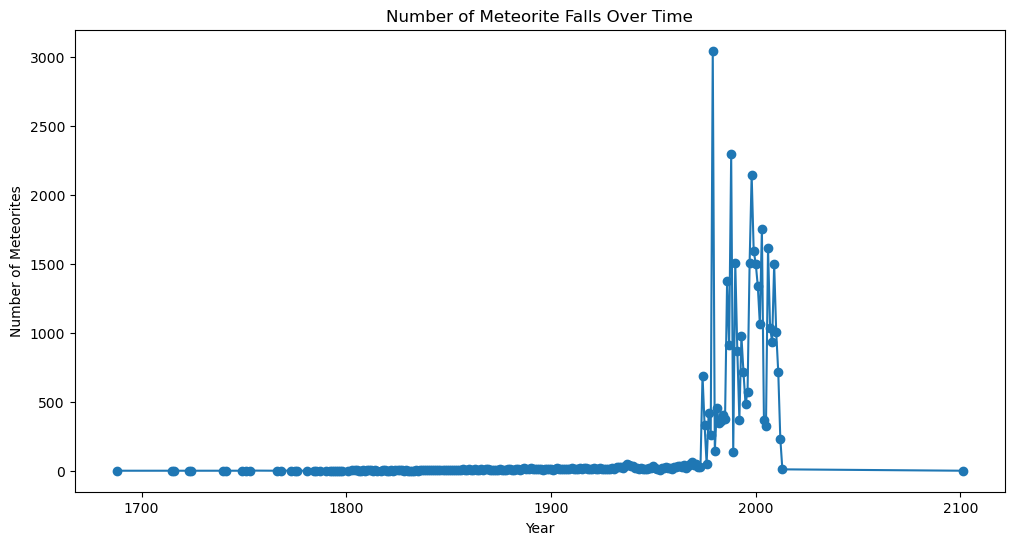

In [35]:
falls_over_time = df.groupby(df['year'].dt.year).size()

plt.figure(figsize=(12, 6))
plt.plot(falls_over_time.index, falls_over_time.values, marker='o')
plt.title('Number of Meteorite Falls Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Meteorites')
# plt.tight_layout()
plt.show()

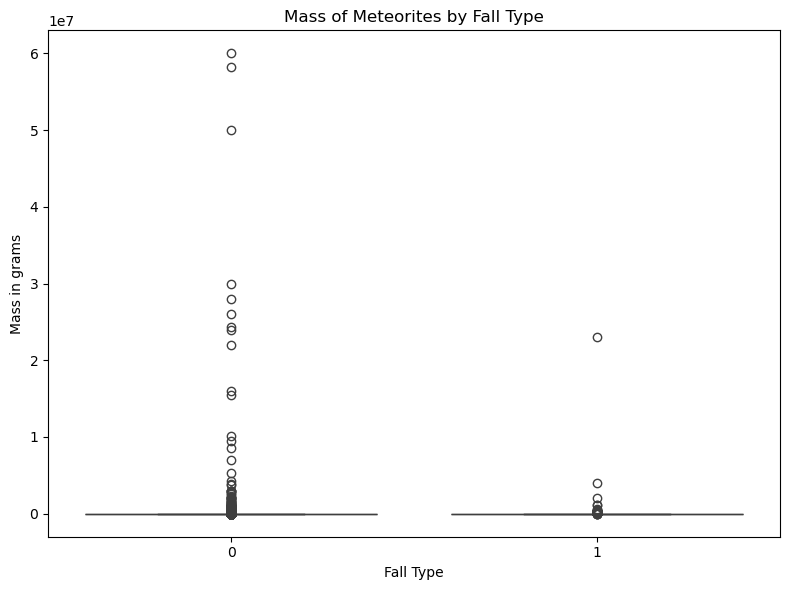

In [36]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='fall', y='mass (g)', data=df)
plt.title('Mass of Meteorites by Fall Type')
plt.xlabel('Fall Type')
plt.ylabel('Mass in grams')
plt.tight_layout()
plt.show()

## **Question 1:** What is the distribution of meteorite classifications (recclass) and how does it differ between observed falls (Fell) and discovered finds (Found)? (descriptive)


### Preprocess for the visualizations

In [39]:
# Minimum total occurrences to be included in a class
min_count = 10  

recclass_fall_counts = df.groupby(['recclass', 'fall']).size().reset_index(name='count')
recclass_pivot = recclass_fall_counts.pivot(index='recclass', columns='fall', values='count').fillna(0)
recclass_pivot.columns = ['Found', 'Fell']
recclass_pivot['total'] = recclass_pivot.sum(axis=1)

# Filter out classes less than min_count as the rare classes
recclass_pivot = recclass_pivot[recclass_pivot['total'] >= min_count].sort_values('total', ascending=False)

# Add a normalized metric
recclass_pivot['fell_ratio'] = recclass_pivot['Fell'] / recclass_pivot['total']  
recclass_pivot['found_ratio'] = 1 - recclass_pivot['fell_ratio']

### Visualize the top 20 classes

In [116]:
import plotly.graph_objects as go

top20 = recclass_pivot.head(20).copy()

# Create figure
fig = go.Figure()

# Stacked bar for 'Fell'
fig.add_trace(go.Bar(
    x=top20.index,
    y=top20['Fell'],
    name='Fell',
    marker_color='#ff6b6b',
    hovertemplate='Fell: %{y}<extra></extra>'
))

# Stacked bar for 'Found'
fig.add_trace(go.Bar(
    x=top20.index,
    y=top20['Found'],
    name='Found',
    marker_color='#4ecdc4',
    hovertemplate='Found: %{y}<extra></extra>'
))

# Line plot for fell_ratio on secondary axis
fig.add_trace(go.Scatter(
    x=top20.index,
    y=top20['fell_ratio'],
    mode='lines+markers',
    name='Fell Ratio (Fell/Total)',
    marker=dict(color='red'),
    yaxis='y2',
    hovertemplate='Fell Ratio: %{y:.2f}<extra></extra>'
))

# Layout with secondary y-axis
fig.update_layout(
    title='Top 20 Meteorite Classes: Counts vs Fall Ratios',
    xaxis=dict(title='Meteorite Class', tickangle=60),
    yaxis=dict(title='Total Count'),
    yaxis2=dict(
        title='Fell Ratio (Fell/Total)',
        overlaying='y',
        side='right',
        range=[0, 1]
    ),
    barmode='stack',
    legend=dict(orientation="h", yanchor="bottom", y=1.1, xanchor="center", x=0.7),
    height=600
)

fig.show()



### Showing the classes with bias

In [43]:
# Show the biased classes (first 10)

print("\nClasses Most Biased Toward Falls:")
display(recclass_pivot.sort_values('fell_ratio', ascending=False).head(10)[['Fell','total','fell_ratio']])

print("\nClasses Most Biased Toward Finds:")
display(recclass_pivot.sort_values('found_ratio', ascending=False).head(10)[['Found','total','found_ratio']])


Classes Most Biased Toward Falls:


,Fell,total,fell_ratio
recclass,,,
Stone-uncl,23.0,29.0,0.793103
OC,18.0,69.0,0.260870
Eucrite-cm,5.0,20.0,0.250000
L,10.0,43.0,0.232558
C2-ung,3.0,13.0,0.230769
L/LL5,3.0,13.0,0.230769
Eucrite-mmict,18.0,84.0,0.214286
H,13.0,69.0,0.188406
"Iron, IAB-sHL",3.0,16.0,0.187500



Classes Most Biased Toward Finds:


,Found,total,found_ratio
recclass,,,
LL3.5,10.0,10.0,1.0
"Iron, IIIE",13.0,13.0,1.0
L3.8,45.0,45.0,1.0
L4/5,47.0,47.0,1.0
LL3.7,16.0,16.0,1.0
L6,54.0,54.0,1.0
LL-melt breccia,54.0,54.0,1.0
R4,16.0,16.0,1.0
Lunar,16.0,16.0,1.0


### Interactive treemap for showing every recclass in 1 go

In [128]:
# Treemap for rare classes (complementary insight)

rare_classes = recclass_fall_counts[~recclass_fall_counts['recclass'].isin(recclass_pivot.index)]
px.treemap(rare_classes, path=['recclass'], values='count', 
           title='Rare Meteorite Classifications (Total < 10)')



## **Question 2:** Investigate whether meteorietes with a higher mass (grams) exhibit distinct classifications patterns or geographic clustering compared to metorites with lower mass (Exploratory)

explore relationships between:
- mass
- classfication (recclass)
- geographic location (reclat, reclong)

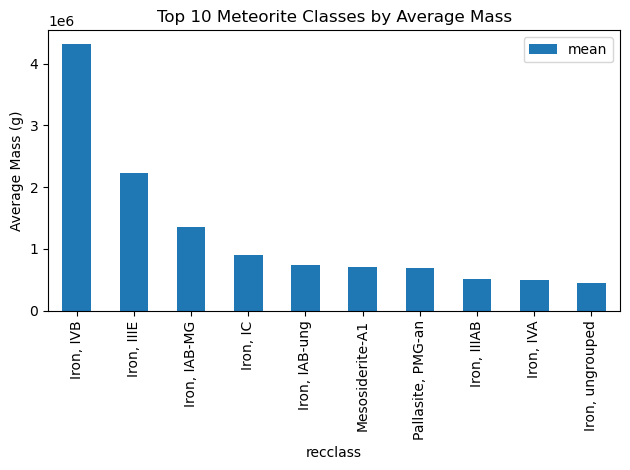

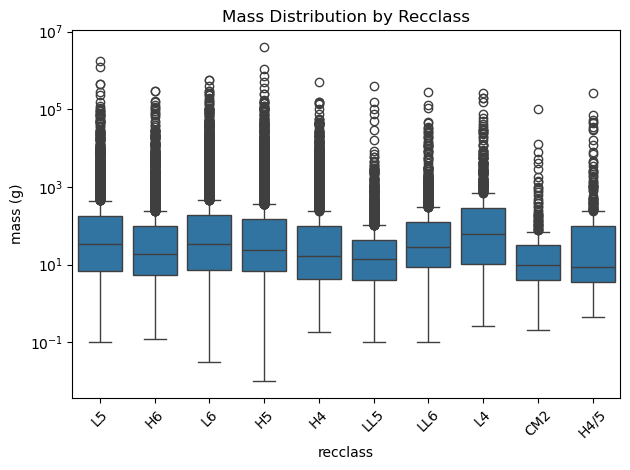

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Group by recclass
class_stats = df.groupby('recclass')['mass (g)'].agg(['count', 'mean', 'median', 'max']).sort_values(by='mean', ascending=False)

# Plot top 10 classes by average mass
class_stats.head(10).plot(kind='bar', y='mean', title='Top 10 Meteorite Classes by Average Mass')
plt.ylabel('Average Mass (g)')
plt.tight_layout()
plt.show()

# Boxplot: Mass distribution per classification
top_classes = df['recclass'].value_counts().head(10).index
sns.boxplot(x='recclass', y='mass (g)', data=df[df['recclass'].isin(top_classes)])
plt.xticks(rotation=45)
plt.yscale('log')  # because mass likely has a long tail
plt.title('Mass Distribution by Recclass')
plt.tight_layout()
plt.show()

In [48]:
# import geopandas as gpd
# import matplotlib.pyplot as plt

# # Filter for valid geolocations and mass
# df_geo = df[df['reclat'].notna() & df['reclong'].notna() & df['mass (g)'].notna()]

# # Scatter plot on map
# # world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
# world = gpd.read_file(url)
# fig, ax = plt.subplots(figsize=(15, 10))
# world.plot(ax=ax, color='lightgray')

# # Normalize mass for better visualization
# sizes = (df_geo['mass (g)'] / df_geo['mass (g)'].max()) * 100

# plt.scatter(df_geo['reclong'], df_geo['reclat'], s=sizes, c=df_geo['mass (g)'], cmap='viridis', alpha=0.5)
# plt.colorbar(label='Mass (g)')
# plt.title('Meteorite Landings: Mass and Geographic Distribution')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.tight_layout()
# plt.show()

In [49]:
print(df['mass (g)'].max())

60000000.0


In [50]:
mass_bins = [0, 500, 1000, 5000, df['mass (g)'].max()]
bin_labels = ['Small', 'Medium', 'Large', 'Very Large']

# Im creating a new column here based on the bins
df['mass_category'] = pd.cut(df['mass (g)'], bins=mass_bins, labels=bin_labels, include_lowest=True) 
#df['mass_category'].head(20) #checking values

fig = px.scatter_mapbox(
    df,
    lat='reclat',
    lon='reclong',
    color='mass_category', 
    size='mass (g)',
    size_max=20,
    mapbox_style='carto-positron',
    title='Meteorite Locations by Mass Category',
    zoom=1,
    height=700,
    hover_name='name',
    hover_data=['mass (g)', 'recclass'],
    category_orders={
        'mass_category': ['Small', 'Medium', 'Large', 'Very Large']  
    }
)
fig.show()

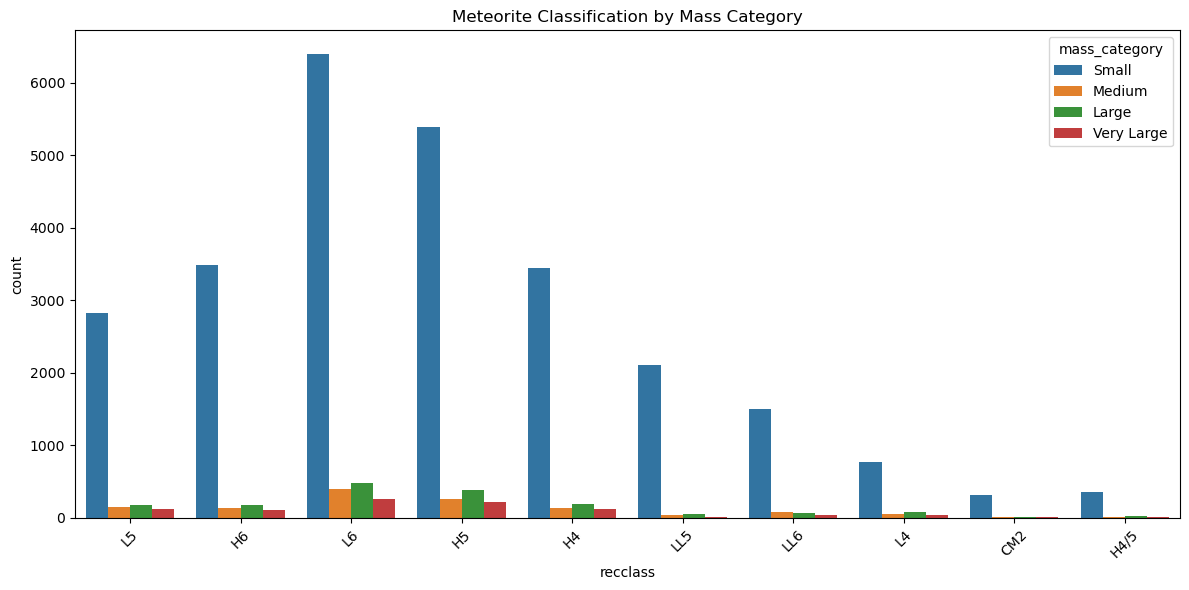

In [51]:
top_classes = df['recclass'].value_counts().nlargest(10).index
df_top = df[df['recclass'].isin(top_classes)]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_top, x='recclass', hue='mass_category')  # or mass_quartile
plt.title('Meteorite Classification by Mass Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Question 3:** Do meteorite falls cluster in specific geographic regions, and can we predict those clusters?

In [53]:
# Plot lat/lon only
fig = px.scatter_mapbox(
    data_frame=df,
    lat='reclat',
    lon='reclong',
    hover_name='name',
    mapbox_style='carto-darkmatter',  # or 'open-street-map', etc.
    zoom=1,
    center={'lat': 0, 'lon': 0},
    height=600,
    title="Meteorite Locations "
)

fig.show()

In [54]:
from sklearn.cluster import KMeans

# Extract coordinates for clustering
coords = df[['reclat', 'reclong']].values

# Set number of clusters (e.g., 5)
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(coords)

In [55]:
fig = px.scatter_mapbox(
    df,
    lat='reclat',
    lon='reclong',
    color='cluster',
    hover_name='name' if 'name' in df.columns else None,
    mapbox_style='carto-darkmatter',
    zoom=1,
    center={'lat': 0, 'lon': 0},
    height=700,
    title="KMeans Clustering of Meteorite Locations"
)

fig.show()

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

features = df[['reclat', 'reclong', 'mass (g)']].fillna(0)
labels = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.9990817263544536


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

features = df[['reclat', 'reclong', 'mass (g)']].fillna(0)
labels = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

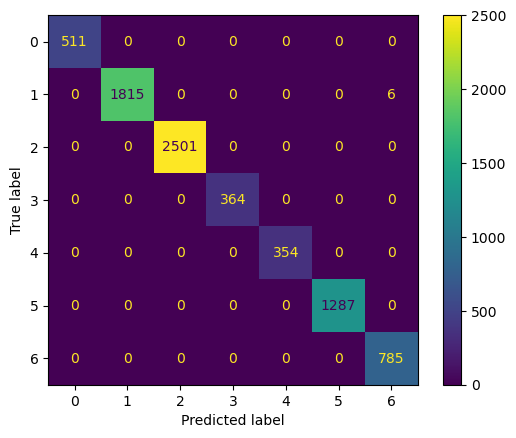

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [59]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9992129083038174
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       511
           1       1.00      1.00      1.00      1821
           2       1.00      1.00      1.00      2501
           3       1.00      1.00      1.00       364
           4       1.00      1.00      1.00       354
           5       1.00      1.00      1.00      1287
           6       0.99      1.00      1.00       785

    accuracy                           1.00      7623
   macro avg       1.00      1.00      1.00      7623
weighted avg       1.00      1.00      1.00      7623



## Question 4: How accurately can classification models predict whether a meteorite fell or was found, using its mass, classification type, and geographic coordinates as input features?

### Predicting Meteorite Origin: Classification Models

#### Objective
**Question**: How accurately can classification models predict whether a meteorite **fell** or was **found**, using its:
- `mass (g)`
- `classification type` (`recclass`)
- `geographic coordinates` (`reclat`, `reclong`)

The goal is to apply and compare different classification algorithms to determine which model best predicts the fall status (`fall` column) of meteorites.

We will explore the following models:
1. **Logistic Regression**
2. **Random Forest Classifier**
3. **Support Vector Machine (SVM)**

Each model will be evaluated using:
- Confusion Matrix
- Classification Report (Precision, Recall, F1-score)
- Visualizations


### Machine Learning Model

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,classification_report
from sklearn.svm import SVC

# Drop irrelevant columns
df = df[['mass (g)', 'recclass', 'reclat', 'reclong', 'fall']].dropna()

# Encode categorical feature
df['recclass'] = LabelEncoder().fit_transform(df['recclass'])

# Features and target
X = df[['mass (g)', 'recclass', 'reclat', 'reclong']]
y = df['fall']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### Logistic Regression

In [65]:
# Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict
lr_pred = lr_model.predict(X_test_scaled)

# Save classification report
lr_report = classification_report(y_test, lr_pred, target_names=["Found", "Fell"], output_dict=True)

# Confusion Matrix
lr_cm = confusion_matrix(y_test, lr_pred)
lr_cm_df = pd.DataFrame(lr_cm, index=['Actual: Found (0)', 'Actual: Fell (1)'],
                                   columns=['Predicted: Found (0)', 'Predicted: Fell (1)'])

# Print results
print("📘 Logistic Regression Confusion Matrix:")
print(lr_cm_df)
print("\n📊 Classification Report:")
print(classification_report(y_test, lr_pred, target_names=["Found", "Fell"]))

📘 Logistic Regression Confusion Matrix:
                   Predicted: Found (0)  Predicted: Fell (1)
Actual: Found (0)                 11100                   13
Actual: Fell (1)                    313                    9

📊 Classification Report:
              precision    recall  f1-score   support

       Found       0.97      1.00      0.99     11113
        Fell       0.41      0.03      0.05       322

    accuracy                           0.97     11435
   macro avg       0.69      0.51      0.52     11435
weighted avg       0.96      0.97      0.96     11435



### Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Predict
rf_pred = rf_model.predict(X_test_scaled)

# Save classification report for later comparison
rf_report = classification_report(y_test, rf_pred, target_names=["Found", "Fell"], output_dict=True)

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_pred)
rf_cm_df = pd.DataFrame(rf_cm, index=['Actual: Found (0)', 'Actual: Fell (1)'],
                                  columns=['Predicted: Found (0)', 'Predicted: Fell (1)'])

# Print results
print("🌳 Random Forest Confusion Matrix:")
print(rf_cm_df)
print("\n📊 Classification Report:")
print(classification_report(y_test, rf_pred, target_names=["Found", "Fell"]))


🌳 Random Forest Confusion Matrix:
                   Predicted: Found (0)  Predicted: Fell (1)
Actual: Found (0)                 11068                   45
Actual: Fell (1)                     87                  235

📊 Classification Report:
              precision    recall  f1-score   support

       Found       0.99      1.00      0.99     11113
        Fell       0.84      0.73      0.78       322

    accuracy                           0.99     11435
   macro avg       0.92      0.86      0.89     11435
weighted avg       0.99      0.99      0.99     11435



### SVM

In [69]:
# Train SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predict
svm_pred = svm_model.predict(X_test_scaled)

# Save classification report
svm_report = classification_report(y_test, svm_pred, target_names=["Found", "Fell"], output_dict=True)

# Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_pred)
svm_cm_df = pd.DataFrame(svm_cm, index=['Actual: Found (0)', 'Actual: Fell (1)'],
                                     columns=['Predicted: Found (0)', 'Predicted: Fell (1)'])

# Print results
print("🔲 SVM Confusion Matrix:")
print(svm_cm_df)
print("\n📊 Classification Report:")
print(classification_report(y_test, svm_pred, target_names=["Found", "Fell"]))

🔲 SVM Confusion Matrix:
                   Predicted: Found (0)  Predicted: Fell (1)
Actual: Found (0)                 11088                   25
Actual: Fell (1)                    252                   70

📊 Classification Report:
              precision    recall  f1-score   support

       Found       0.98      1.00      0.99     11113
        Fell       0.74      0.22      0.34       322

    accuracy                           0.98     11435
   macro avg       0.86      0.61      0.66     11435
weighted avg       0.97      0.98      0.97     11435



### Visual Comparison of Confusion Matrices

Below are the confusion matrices for the three models. Logistic Regression, Random Forest, and SVM. These matrices visually represent how well each model performed in classifying the meteorites as "Found" or "Fell".

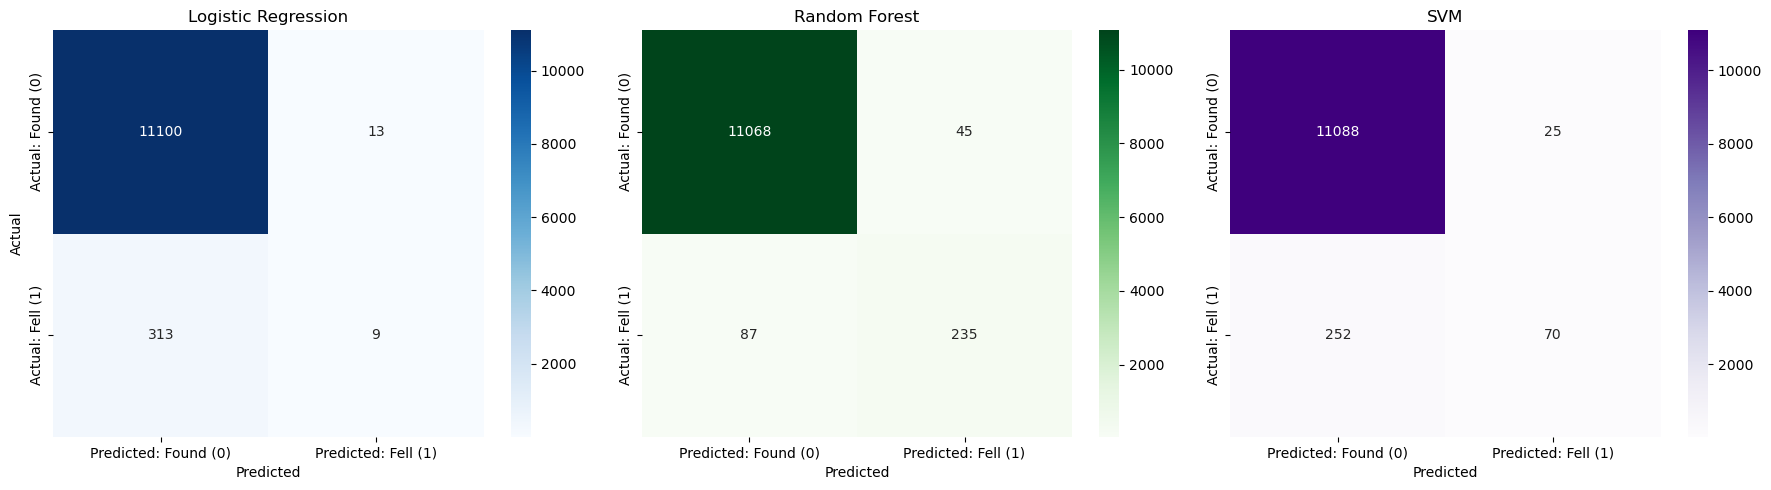

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Logistic Regression
sns.heatmap(lr_cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Random Forest
sns.heatmap(rf_cm_df, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Random Forest")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

# SVM
sns.heatmap(svm_cm_df, annot=True, fmt='d', cmap='Purples', ax=axes[2])
axes[2].set_title("SVM")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

In [72]:
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    "Accuracy": [lr_report['accuracy'], rf_report['accuracy'], svm_report['accuracy']],
    "Precision (Fell)": [lr_report['Fell']['precision'], rf_report['Fell']['precision'], svm_report['Fell']['precision']],
    "Recall (Fell)": [lr_report['Fell']['recall'], rf_report['Fell']['recall'], svm_report['Fell']['recall']],
    "F1-Score (Fell)": [lr_report['Fell']['f1-score'], rf_report['Fell']['f1-score'], svm_report['Fell']['f1-score']]
})

comparison_df.set_index("Model", inplace=True)
comparison_df = comparison_df.round(3)
display(comparison_df)

,Accuracy,Precision (Fell),Recall (Fell),F1-Score (Fell)
Model,,,,
Logistic Regression,0.971,0.409,0.028,0.052
Random Forest,0.988,0.839,0.730,0.781
SVM,0.976,0.737,0.217,0.336


### Interpretation:

- **Logistic Regression** shows high overall accuracy but fails to capture "Fell" cases — very low recall and F1-score.
- **SVM** improves on logistic regression but still underperforms in recall for the "Fell" class.
- **Random Forest** clearly outperforms the others in all metrics related to the minority class ("Fell").

---

### Final Verdict:
**Random Forest Classifier** is the best model for this classification task. It balances precision and recall effectively, especially for the underrepresented class, and delivers the most robust results.
